In [63]:
import warnings
warnings.filterwarnings("ignore")
import MENDER
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.metrics import *
import time

In [64]:
import pysodb
sodb = pysodb.SODB()
adata_raw = sodb.load_experiment('Lebrigand2022The','GSM4656181_10x_Visium')

load experiment[GSM4656181_10x_Visium] in dataset[Lebrigand2022The]


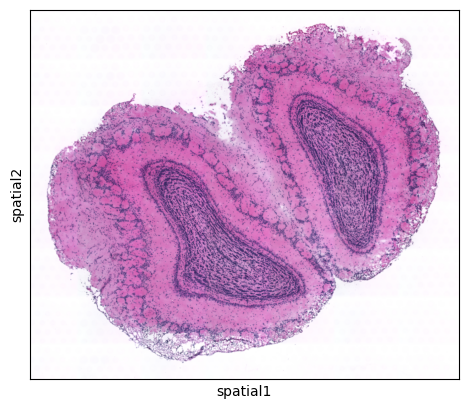

In [65]:
ax = sc.pl.spatial(adata_raw,color=None,show=False)

In [66]:
adata_raw 

AnnData object with n_obs × n_vars = 918 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

### PCA

In [67]:
## Use PCA to determine cell state (CT)
adata_pca = adata_raw.copy()

# Preprocess: normalize and log transform 
sc.pp.highly_variable_genes(adata_pca, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata_pca, inplace=True)
sc.pp.log1p(adata_pca)

# Run PCA followed by neighborhood search and Leiden clustering
sc.pp.pca(adata_pca)
sc.pp.neighbors(adata_pca)
sc.tl.leiden(adata_pca,resolution=2,key_added='ct_pca')
adata_pca.obs['ct_pca'] = adata_pca.obs['ct_pca'].astype('category')

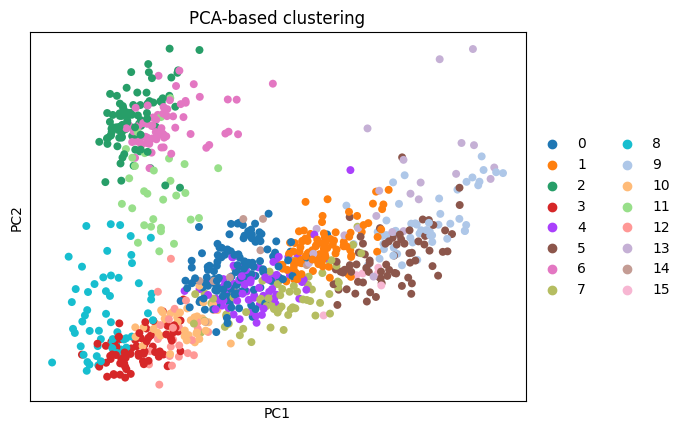

In [68]:
# Visualize the clusters (cell types) that were identified
sc.pl.pca(adata_pca, color='ct_pca', title='PCA-based clustering')

In [69]:
# input parameters of MENDER
scale = 2

# main body of MENDER
msm = MENDER.MENDER_single(
    adata_pca,
    # determine which cell state to use
    # we use the cell state got by Leiden
    ct_obs='ct_pca'
)


# set the MENDER parameters


msm.set_MENDER_para(
    # default of n_scales is 6
    n_scales=scale,

    # for single cell data, nn_mode is set to 'radius'
    # for spot data, nn_mode is set to 'ring', since each spot is surrounded by certain number of spots (6 for visium and 4 for ST)

    nn_mode='ring',

    # default of n_scales is 15 um (see the manuscript for why).
    # MENDER also provide a function 'estimate_radius' for estimating the radius
    # if nn_mode is set to 'ring', nn_para means the number of spots around the central spot, i.e., 6 for Visium and 4 for ST
    nn_para=6,

)
# construct the context representation
msm.run_representation(

    # the number of processings
)

# set the spatial clustering parameter
# positive values for the expected number of domains
# negative values for the clustering resolution
msm.run_clustering_normal(-0.2)

scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0


In [70]:
from MENDER.utils import compute_NMI, compute_PAS, compute_CHAOS

# Compute evaluation metrics after MENDER spatial domains (NMI, PAS and CHAOS)
msm.adata_MENDER.obs['ct_pca'] = adata_pca.obs['ct_pca']

nmi = compute_NMI(msm.adata_MENDER, gt_key='ct_pca', pred_key='MENDER')
pas = compute_PAS(msm.adata_MENDER, pred_key='MENDER')
chaos = compute_CHAOS(msm.adata_MENDER, pred_key='MENDER')

print(f"NMI: {nmi:.3f}")
print(f"PAS: {pas:.3f}")
print(f"CHAOS: {chaos:.3f}")


NMI: 0.442
PAS: 0.026
CHAOS: 0.107


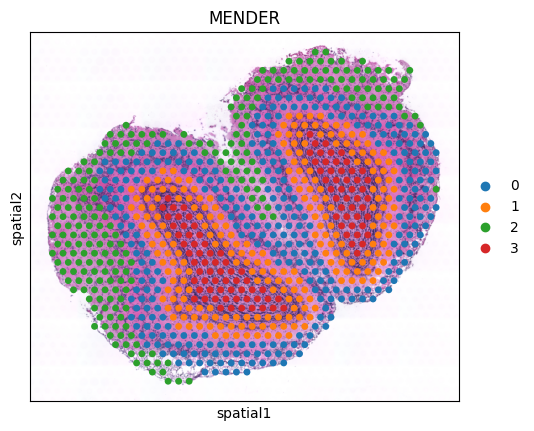

In [71]:
sc.pl.spatial(msm.adata_MENDER,color='MENDER',size=1)

### UMAP

In [72]:
adata_umap = adata_raw.copy()

In [73]:
## Use UMAP to determine cell state (CT) ##
sc.pp.highly_variable_genes(adata_umap, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata_umap, inplace=True)
sc.pp.log1p(adata_umap)

# Run UMAP followed by neighborhood search and Leiden clustering
sc.pp.pca(adata_umap, n_comps=30)
sc.pp.neighbors(adata_umap, n_pcs=30)
sc.tl.umap(adata_umap)

sc.tl.leiden(adata_umap,resolution=2,key_added='ct_umap')
adata_umap.obs['ct_umap'] = adata_umap.obs['ct_umap'].astype('category')

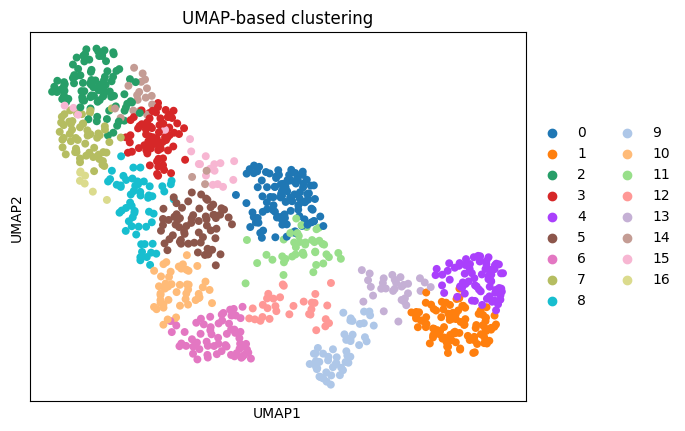

In [74]:
# Visualize clusters (cell types) on UMAP
sc.pl.umap(adata_umap, color='ct_umap', title='UMAP-based clustering')

In [75]:
# input parameters of MENDER
scale = 2

# main body of MENDER
msm = MENDER.MENDER_single(
    adata_umap ,
    ct_obs='ct_umap'
)


# set the MENDER parameters
msm.set_MENDER_para(
    n_scales=scale,
    nn_mode='ring',
    nn_para=6,
)

# construct the context representation
msm.run_representation()

# set the spatial clustering parameter
# positive values for the expected number of domains
# negative values for the clustering resolution
msm.run_clustering_normal(-0.2)

scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0


In [76]:
# Compute evaluation metrics after MENDER spatial domains (NMI, PAS and CHAOS)
msm.adata_MENDER.obs['ct_umap'] = adata_umap.obs['ct_umap']

nmi = compute_NMI(msm.adata_MENDER, gt_key='ct_umap', pred_key='MENDER')
pas = compute_PAS(msm.adata_MENDER, pred_key='MENDER')
chaos = compute_CHAOS(msm.adata_MENDER, pred_key='MENDER')

print(f"NMI: {nmi:.3f}")
print(f"PAS: {pas:.3f}")
print(f"CHAOS: {chaos:.3f}")

NMI: 0.424
PAS: 0.020
CHAOS: 0.106


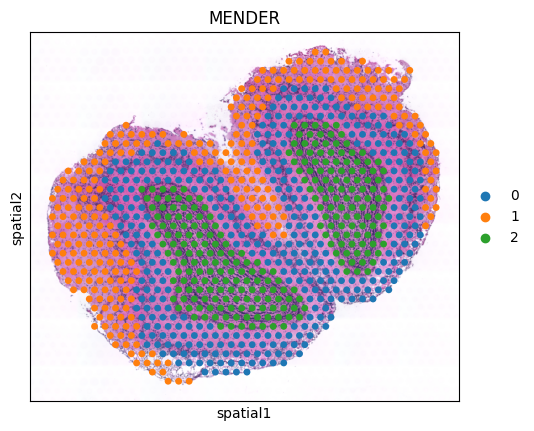

In [77]:
sc.pl.spatial(msm.adata_MENDER,color='MENDER',size=1)

### PCA vs UMAP

In [78]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(adata_pca.obs['ct_pca'], adata_umap.obs['ct_umap'])
nmi = normalized_mutual_info_score(adata_pca.obs['ct_pca'], adata_umap.obs['ct_umap'])

print(f"Cell group ARI (PCA vs UMAP): {ari:.3f}")
print(f"Cell group NMI (PCA vs UMAP): {nmi:.3f}")


Cell group ARI (PCA vs UMAP): 0.715
Cell group NMI (PCA vs UMAP): 0.823


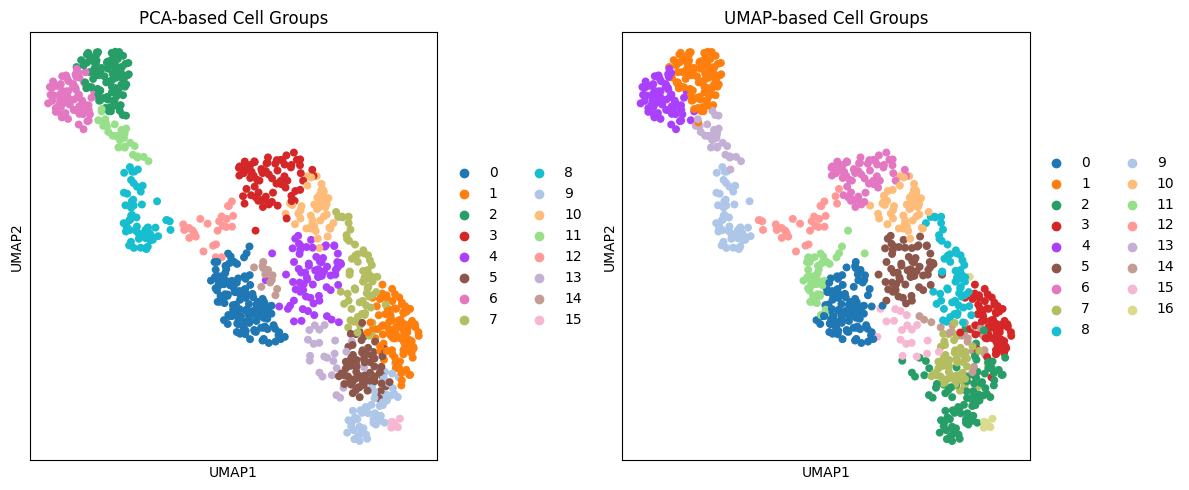

In [79]:
import matplotlib.pyplot as plt

# Ensure UMAP is computed on PCA data 
sc.tl.umap(adata_pca)
adata_umap.obsm['X_umap'] = adata_pca.obsm['X_umap']

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.umap(adata_pca, color='ct_pca', title='PCA-based Cell Groups', ax=axes[0], show=False)
sc.pl.umap(adata_umap, color='ct_umap', title='UMAP-based Cell Groups', ax=axes[1], show=False)
plt.tight_layout()
plt.show()


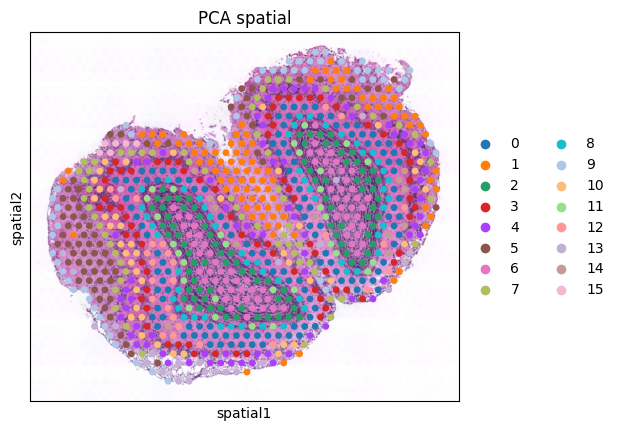

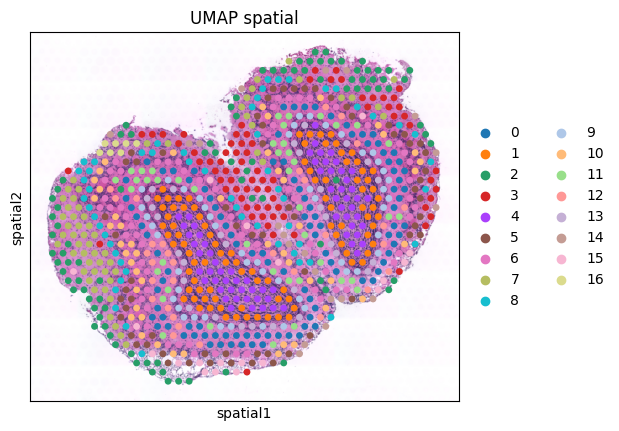

In [80]:
sc.pl.spatial(adata_pca, color='ct_pca', title='PCA spatial')
sc.pl.spatial(adata_umap, color='ct_umap', title='UMAP spatial')

### Tuning number of principle components


##### n_components = 10 #####
Cell group ARI (vs PCA): 0.570
Cell group NMI (vs PCA): 0.745
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
Spatial NMI: 0.410
PAS: 0.029
CHAOS: 0.106


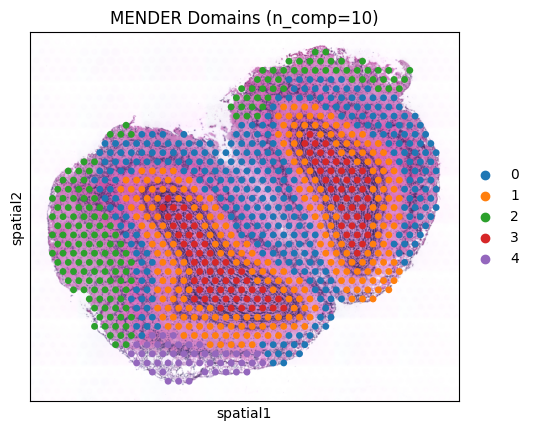


##### n_components = 20 #####
Cell group ARI (vs PCA): 0.662
Cell group NMI (vs PCA): 0.781
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
Spatial NMI: 0.448
PAS: 0.034
CHAOS: 0.107


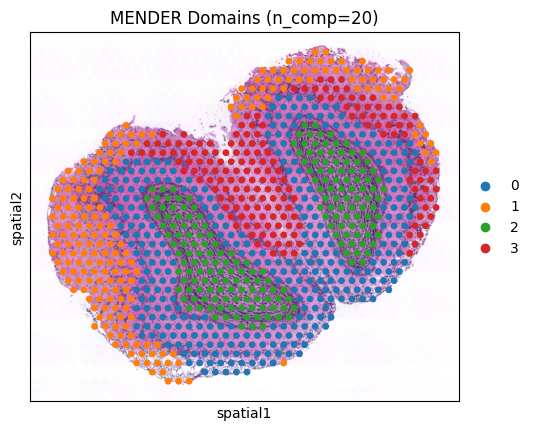


##### n_components = 30 #####
Cell group ARI (vs PCA): 0.715
Cell group NMI (vs PCA): 0.823
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
Spatial NMI: 0.424
PAS: 0.020
CHAOS: 0.106


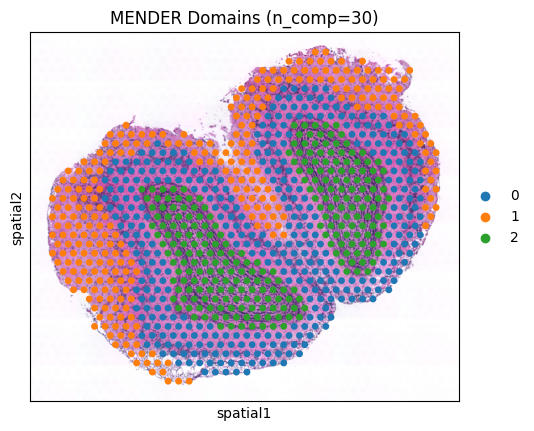


##### n_components = 40 #####
Cell group ARI (vs PCA): 0.698
Cell group NMI (vs PCA): 0.816
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
Spatial NMI: 0.425
PAS: 0.021
CHAOS: 0.106


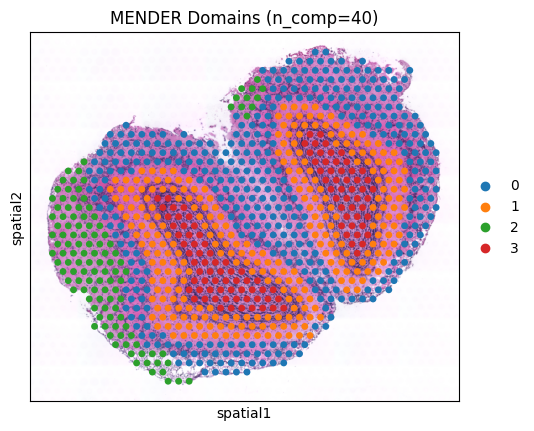


##### n_components = 50 #####
Cell group ARI (vs PCA): 1.000
Cell group NMI (vs PCA): 1.000
scale 0, median #cells per ring (r=6): 7.0
scale 1, median #cells per ring (r=6): 12.0
Spatial NMI: 0.442
PAS: 0.026
CHAOS: 0.107


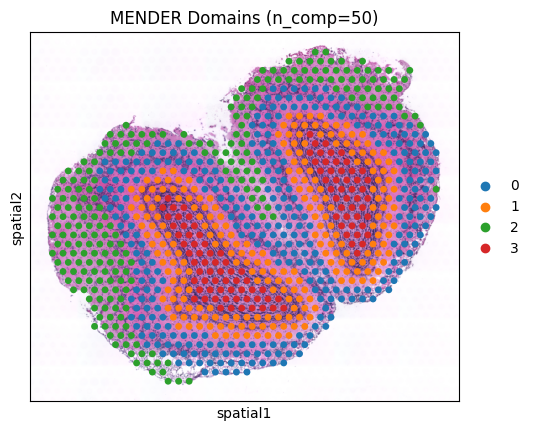

In [82]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

component_list = [10, 20, 30, 40, 50]

for n_comp in component_list:
    print(f"\n##### n_components = {n_comp} #####")

    # Copy and preprocess data
    adata_umap = adata_raw.copy()
    sc.pp.highly_variable_genes(adata_umap, flavor="seurat_v3", n_top_genes=4000)
    sc.pp.normalize_total(adata_umap, inplace=True)
    sc.pp.log1p(adata_umap)

    # Dimensionality reduction and clustering
    sc.pp.pca(adata_umap, n_comps=n_comp)
    sc.pp.neighbors(adata_umap, n_pcs=n_comp)
    sc.tl.umap(adata_umap)
    sc.tl.leiden(adata_umap, resolution=2, key_added=f'ct_umap_{n_comp}')
    adata_umap.obs[f'ct_umap_{n_comp}'] = adata_umap.obs[f'ct_umap_{n_comp}'].astype('category')

    # Cell group agreement: compare to ct_pca
    adata_umap.obs['ct_pca'] = adata_pca.obs['ct_pca']
    ari = adjusted_rand_score(adata_umap.obs['ct_pca'], adata_umap.obs[f'ct_umap_{n_comp}'])
    nmi_cell = normalized_mutual_info_score(adata_umap.obs['ct_pca'], adata_umap.obs[f'ct_umap_{n_comp}'])

    print(f"Cell group ARI (vs PCA): {ari:.3f}")
    print(f"Cell group NMI (vs PCA): {nmi_cell:.3f}")

    # Run MENDER on UMAP clustering
    msm = MENDER.MENDER_single(adata_umap, ct_obs=f'ct_umap_{n_comp}')
    msm.set_MENDER_para(n_scales=2, nn_mode='ring', nn_para=6)
    msm.run_representation()
    msm.run_clustering_normal(-0.2)

    # Spatial domain agreement
    msm.adata_MENDER.obs[f'ct_umap_{n_comp}'] = adata_umap.obs[f'ct_umap_{n_comp}']
    nmi_dom = compute_NMI(msm.adata_MENDER, gt_key=f'ct_umap_{n_comp}', pred_key='MENDER')
    pas = compute_PAS(msm.adata_MENDER, pred_key='MENDER')
    chaos = compute_CHAOS(msm.adata_MENDER, pred_key='MENDER')

    print(f"Spatial NMI: {nmi_dom:.3f}")
    print(f"PAS: {pas:.3f}")
    print(f"CHAOS: {chaos:.3f}")

    # Visualize MENDER domains
    sc.pl.spatial(msm.adata_MENDER, color='MENDER', size=1, title=f'MENDER Domains (n_comp={n_comp})')
